# Sentiment Analysis

The following project aims to analyze and group the sentiment of tweets regarding major airlines operating in the US into three broad categories, namely positive, neutral, and negative.

Sentiment Analysis is a novel concept, part of the larger idea of Natural Language Processing(NLP, and works with actual human languages, to derive the context behind them underlying speach.
Determining the Positive or Negative aspects of the data is called measuring the Polarity of the Content.


This particular DataSet contains the sentiment of the tweets as positive, neutral, or negative for the following six carriers:

1. American
2. Delta
3. SouthWest
4. United
5. US Airways
6. Virgin America

In [796]:
import pandas as pd
import numpy as np

file_path = 'Datasets/Tweets.csv'
tweets_df = pd.read_csv(file_path)

In [797]:
tweets_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [798]:
tweets_df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

# Preprocessing the Data

## Missing Entries
From the initial looks of the data, it has a large number of missing entries, with several columns having very little or no data at all.

### Dropping Some Columns
Considering how most of this data is largely irrelevant to the model prediction, it is safe to drop some of it while retaining other columns to prevent overfitting of the data, while ensuring the model has enough data to learn from and identify patterns out of.

In [799]:
tweets_df.drop(['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 'tweet_location', 'user_timezone'], 
               axis = 1,
               inplace = True)

In [800]:
tweets_df.isna().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
negativereason_confidence       4118
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
dtype: int64

### Retaining Some Missing Data Subsets

Considering how a negative reason is arbitrary and subjective, it cannot be predicted in any way, and missing entries are filled with empty strings. It is however, important to the set as the presence of an entry helps the model identify patterns better.

The negativereason_confidence is filled with the mean of the entries in the column as it is a numeric quantity.
As the data contains unequal proportions of the three categories of data, replacing with median would have led to contamination of the training data.

In [801]:
tweets_df['negativereason_confidence'].replace(np.nan, tweets_df['negativereason_confidence'].mean(), inplace = True)
tweets_df['negativereason'].replace(np.nan, '', inplace = True)

In [802]:
tweets_df.isna().sum()

tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
name                            0
retweet_count                   0
text                            0
tweet_created                   0
dtype: int64

In [803]:
tweets_df['tweet_length'] = tweets_df.text.apply(lambda x : len(x))
tweets_df.rename(columns = {'text' : 'tweet'}, 
                inplace = True)

In [804]:
tweets_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,tweet,tweet_created,tweet_length
0,570306133677760513,neutral,1.0000,,0.638298,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,35
1,570301130888122368,positive,0.3486,,0.000000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,72
2,570301083672813571,neutral,0.6837,,0.638298,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,71
3,570301031407624196,negative,1.0000,Bad Flight,0.703300,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,126
4,570300817074462722,negative,1.0000,Can't Tell,1.000000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,55


In [805]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [806]:
def wordcloud_generator(text):
    words = ' '.join([word for word in text.tweet if word[0] != '@'])
    
    wordcloud = WordCloud(width = 1000, height = 800,
                         max_font_size = 110,
                         collocations = False).generate(words)
    plt.figure(figsize = (20, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    

# Data Visualization

Helping us understand the key drivers of the data, helping us to fine tune our model and select appropriate data subsets.

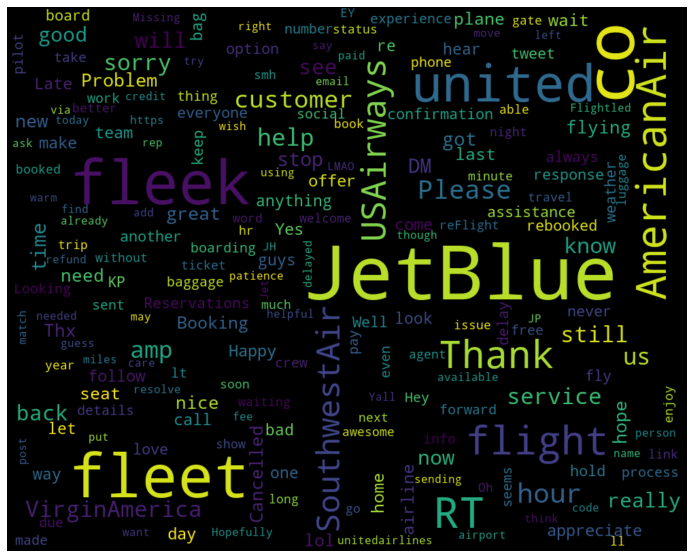

In [807]:
wordcloud_generator(tweets_df)

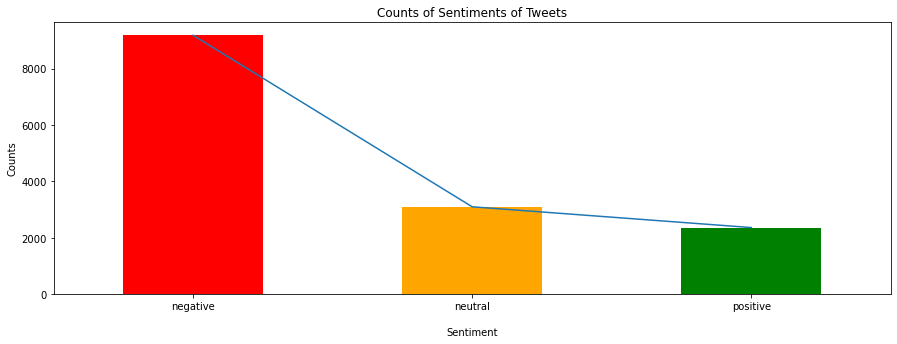

In [808]:
tweets_df.airline_sentiment.value_counts().plot(figsize = (15, 5),
                                        kind = 'bar',
                                        color = ['red', 'orange', 'green'],
                                        title = 'Counts of Sentiments of Tweets',
                                        rot = 0)

tweets_df.airline_sentiment.value_counts().plot()

plt.xlabel('\nSentiment')
plt.ylabel('Counts')

plt.show()

## Unequal Distribution of Data

Greater number of negative tweets.

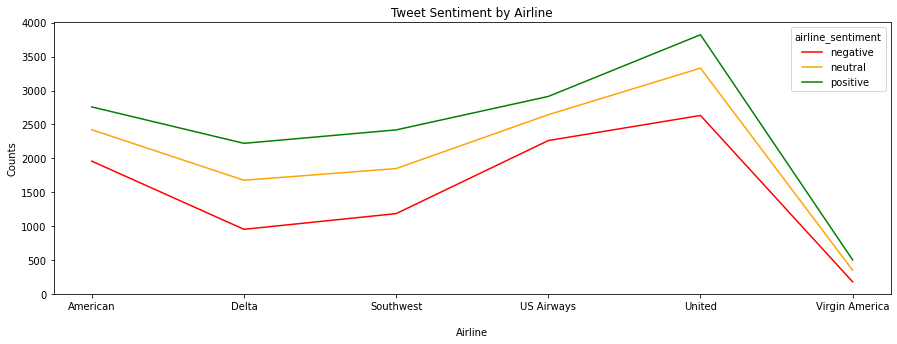

In [809]:
tweets_df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(figsize = (15, 5),
                                                                          stacked = True,
                                                                          color = ['red', 'orange', 'green'],
                                                                          rot = 0)

plt.title('Tweet Sentiment by Airline')
plt.xlabel('\nAirline')
plt.ylabel('Counts')

plt.show()

<ipython-input-810-23c5d7464db2>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_formatter(plt.NullFormatter())


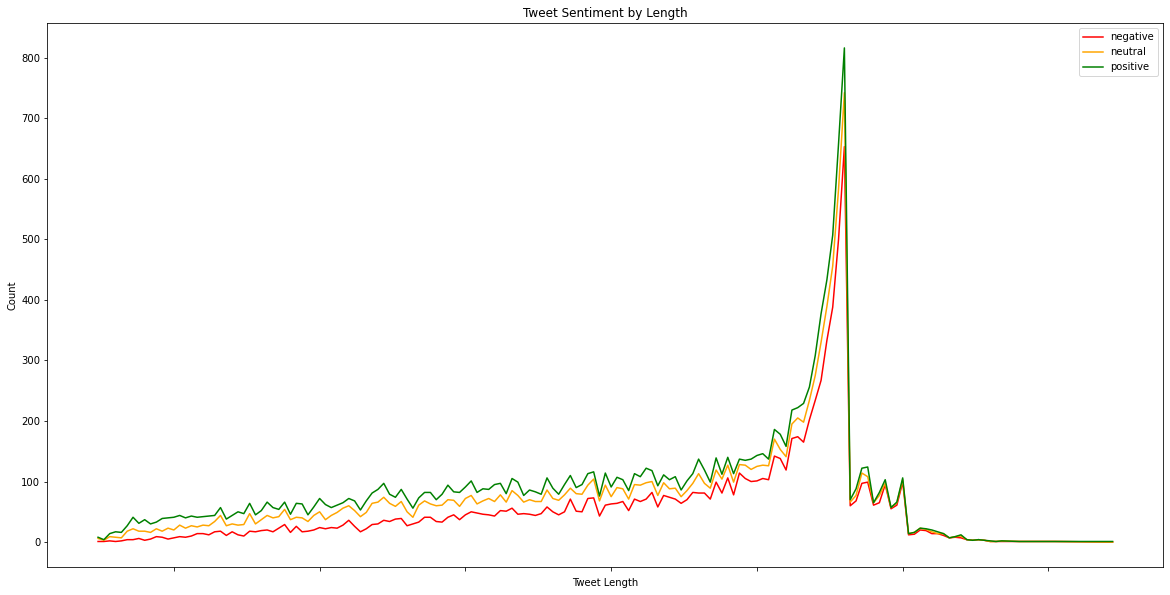

In [810]:
tweets_df.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(figsize = (20, 10),
                                                                               stacked = True,
                                                                               
                                                                              color = ['red', 'orange', 'green'],
                                                                              rot = 0)

plt.axes().xaxis.set_major_formatter(plt.NullFormatter())

plt.legend()

plt.title('Tweet Sentiment by Length')
plt.xlabel('Tweet Length')
plt.ylabel('Count')

plt.show()

## No Apparent Trend, Need for Binning

As is apparent, the data length has no direct imapact on the tweet sentiment. However divinding the data into bins would enable the model to identify micro-trends in data.

8 bins are used to ensure that every major trend in the co-relation between tweet length and sentiment are captured without error.

In [811]:
bins_2D = np.linspace(tweets_df.tweet_length.nsmallest(1), tweets_df.tweet_length.nlargest(1), 9)
print(bins_2D)
bins = list()
for entries in bin:
    for data in entries:
        bins.append(data)
print(bins)

group_names = '1 2 3 4 5 6 7 8'.split(' ')
tweets_df['length_binned'] = pd.cut(tweets_df['tweet_length'], bins, labels = group_names, include_lowest = True)

[[ 12.  ]
 [ 33.75]
 [ 55.5 ]
 [ 77.25]
 [ 99.  ]
 [120.75]
 [142.5 ]
 [164.25]
 [186.  ]]
[12.0, 33.75, 55.5, 77.25, 99.0, 120.75, 142.5, 164.25, 186.0]


In [812]:
correlation = tweets_df.corr()
correlation.style.background_gradient(cmap = 'coolwarm', axis = None).set_precision(3)

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count,tweet_length
tweet_id,1.000,0.025,0.018,-0.009,0.035
airline_sentiment_confidence,0.025,1.000,0.603,0.013,0.161
negativereason_confidence,0.018,0.603,1.000,0.019,0.129
retweet_count,-0.009,0.013,0.019,1.000,0.028
tweet_length,0.035,0.161,0.129,0.028,1.000


## No Apparent Direct Co-Relation between Paramtres

The only major direct proportionality relation exists between two parametres. Thus, we would try the Naive Bayes model first, considering:

1. The NV Model works on the assumption that a particular feature is independent of any other feature.
2. A Linear Model works on the principle that there exist a direct relation between paramtres.
3. Non-Linear models, such a Decision Tress and Random Forests are better suited for numerical data.

In [813]:
tweets_df.dtypes

tweet_id                           int64
airline_sentiment                 object
airline_sentiment_confidence     float64
negativereason                    object
negativereason_confidence        float64
airline                           object
name                              object
retweet_count                      int64
tweet                             object
tweet_created                     object
tweet_length                       int64
length_binned                   category
dtype: object

In [814]:
tweets_df.length_binned = tweets_df.length_binned.astype('object')
tweets_df.airline_sentiment_confidence = tweets_df.airline_sentiment_confidence.apply(lambda x: str(x))
tweets_df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence     object
negativereason                   object
negativereason_confidence       float64
airline                          object
name                             object
retweet_count                     int64
tweet                            object
tweet_created                    object
tweet_length                      int64
length_binned                    object
dtype: object

In [815]:
def converter(text):
    if text == 'negative':
        return -1
    elif text == 'positive':
        return 1
    else:
        return 0

# Grouping Useful Data Subsets fro Preprocessing

In [816]:
tweets_df.airline_sentiment = tweets_df.airline_sentiment.apply(converter)

tweets_df['Text'] = tweets_df.airline_sentiment_confidence + ' ' + tweets_df.length_binned + ' ' + tweets_df.negativereason + ' ' + tweets_df.tweet

tweets_df.Text = tweets_df.Text.apply([lambda x: x.lower()])

# Shuffling Data

The DataSet had previsouly been sorted on the basis of day of tweets. Those are subject to physcial paramtres such as the weather on that particular and would influence the data for a particualr period, thus Contaminating the training DataSet.

In [817]:
tweets_df = tweets_df.sample(frac = 1)
tweets_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,tweet,tweet_created,tweet_length,length_binned,Text
9383,569960704717008896,-1,1.0,Lost Luggage,0.649400,US Airways,Taryn_Sunstrom,0,@USAirways you guys Cancelled Flightled two of...,2015-02-23 12:43:16 -0800,134,6,1.0 6 lost luggage @usairways you guys cancell...
5087,569357127040540673,-1,1.0,Customer Service Issue,0.692500,Southwest,enzo_the_baker,0,@SouthwestAir I was on hold for over 2 hours a...,2015-02-21 20:44:51 -0800,88,4,1.0 4 customer service issue @southwestair i w...
2497,569164614921019392,-1,0.3627,Can't Tell,0.362700,United,AviNewYork,0,@united Finally I get the right response. Unit...,2015-02-21 07:59:53 -0800,110,5,0.3627 5 can't tell @united finally i get the ...
2591,569012722169466880,1,0.7021,,0.638298,United,robbshurr,0,"@United, will you fill it? Yes they will. Than...",2015-02-20 21:56:19 -0800,101,5,"0.7021 5 @united, will you fill it? yes they ..."
790,570079868253298688,-1,1.0,Customer Service Issue,1.000000,United,fortytoo,0,"@united tried calling too, but w/25 min phn wa...",2015-02-23 20:36:46 -0800,79,4,1.0 4 customer service issue @united tried cal...


In [818]:
tweets_df.shape

(14640, 13)

In [819]:
tweets_df.Text

9383    1.0 6 lost luggage @usairways you guys cancell...
5087    1.0 4 customer service issue @southwestair i w...
2497    0.3627 5 can't tell @united finally i get the ...
2591    0.7021 5  @united, will you fill it? yes they ...
790     1.0 4 customer service issue @united tried cal...
                              ...                        
4042    1.0 2 can't tell @united you already have vomi...
1736    0.6735 3  @united thx, just dm'd. conf #'s mqx...
5830                     0.6667 1  @southwestair dm sent.
4912    1.0 6 lost luggage @southwestair couldn't be b...
363     0.6548 3  @virginamerica ok! first time flying...
Name: Text, Length: 14640, dtype: object

# Data Cleaning and Optimization

The grouped data is cleaned and the unncessary entries such as punctuations and other such words are removed.

In [820]:
import string

def cleaning(text):
    return  ''.join([words for words in text if words not in string.punctuation])

In [821]:
import nltk
from nltk.corpus import stopwords
from collections import Counter

stop_words = stopwords.words('english')
global stopwords_dict
stopwords_dict = Counter()

In [822]:
def optimizer(text):
    return ' '.join([words for words in text.split() if words not in stopwords_dict])

In [823]:
tweets_df.Text = tweets_df.Text.apply(optimizer)
tweets_df.Text = tweets_df.Text.apply(cleaning)

tweets_df.Text

9383    10 6 lost luggage usairways you guys cancelled...
5087    10 4 customer service issue southwestair i was...
2497    03627 5 cant tell united finally i get the rig...
2591    07021 5 united will you fill it yes they will ...
790     10 4 customer service issue united tried calli...
                              ...                        
4042    10 2 cant tell united you already have vomit s...
1736    06735 3 united thx just dmd conf s mqxc64 amp ...
5830                         06667 1 southwestair dm sent
4912    10 6 lost luggage southwestair couldnt be both...
363     06548 3 virginamerica ok first time flying wit...
Name: Text, Length: 14640, dtype: object

# Tokenization of Data

## Bag of Words

In [824]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer().fit(tweets_df.Text)
Text_bow = vectorizer.transform(tweets_df.Text)

## Vector, Tf-Idf

The data entries are converted into their vector form with Tf-Idf Vectorization so it can be easily processed by the model.

In [825]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(Text_bow)
Text_tfidf = transformer.transform(Text_bow)

print(Text_tfidf.shape)

(14640, 17654)


# Splitting into Testing and Training Sets

20% of the data is used for Model Training, while the rest is used for Model Validation.

In [826]:
from sklearn.model_selection import train_test_split

X = Text_tfidf
y = tweets_df.airline_sentiment

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                   train_size = 0.2,
                                                   random_state = 1)

In [827]:
#Confusion Matrix adopted from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predictions, model_name):
    cm = confusion_matrix(test_y, predictions)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    plt.title('Confusion matrix of the classifier')

    # labels, title and ticks
    ax.set_xlabel('\nPredicted Labels')
    ax.set_ylabel('True Labels')
    
    title = 'Confusion Matrix for ' + model_name
    ax.set_title(title)
    ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
    ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])
    plt.show()

# Model Testing

In [828]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB().fit(train_X, train_y)
predictions = model.predict(test_X)
predictions

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [829]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

print('Mean Absolute Error: {}'.format(mean_absolute_error(test_y, predictions)))
print('-' * 76)
print('Classification Report:', classification_report(test_y, predictions))

Mean Absolute Error: 0.5241632513661202
----------------------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

          -1       0.63      1.00      0.78      7374
           0       0.93      0.03      0.06      2423
           1       1.00      0.01      0.02      1915

    accuracy                           0.64     11712
   macro avg       0.85      0.35      0.28     11712
weighted avg       0.75      0.64      0.50     11712



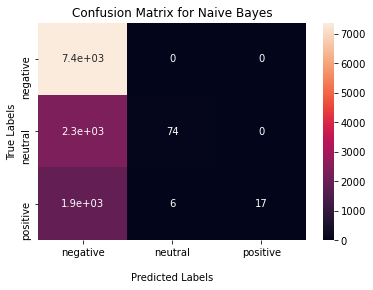

In [830]:
plot_confusion_matrix(test_y, predictions, 'Naive Bayes')

## Existence of Linear Relationships between Features

The Naive Bayes model proves inefficient while handling the data, proving the existence of Linear Relationships between Paramtres.

Therefore the data is tested with Linear Regression Models, particularly:
1. Logistic Regression
2. Sophisticated Gradient Descent Classifier
3. Linear Support Vector Classifier

In [831]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(train_X, train_y)
predictions = model.predict(test_X)
predictions

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [832]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(test_y, predictions)))
print('-' * 76)
print('Classification Report:', classification_report(test_y, predictions))

Mean Absolute Error: 0.15462773224043716
----------------------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

          -1       0.91      1.00      0.95      7374
           0       0.74      0.78      0.76      2423
           1       0.90      0.50      0.65      1915

    accuracy                           0.87     11712
   macro avg       0.85      0.76      0.79     11712
weighted avg       0.87      0.87      0.86     11712



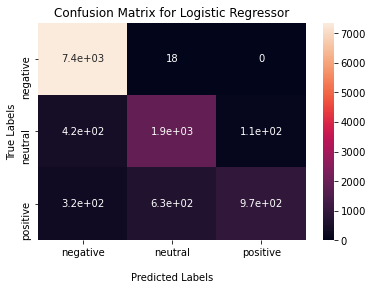

In [833]:
plot_confusion_matrix(test_y, predictions, 'Logistic Regressor')

In [834]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier().fit(train_X, train_y)
predictions = model.predict(test_X)
predictions

array([-1,  0, -1, ..., -1, -1, -1], dtype=int64)

In [835]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(test_y, predictions)))
print('-' * 76)
print('Classification Report:', classification_report(test_y, predictions))

Mean Absolute Error: 0.1135587431693989
----------------------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

          -1       0.96      0.99      0.97      7374
           0       0.77      0.82      0.79      2423
           1       0.84      0.64      0.72      1915

    accuracy                           0.90     11712
   macro avg       0.85      0.82      0.83     11712
weighted avg       0.90      0.90      0.90     11712



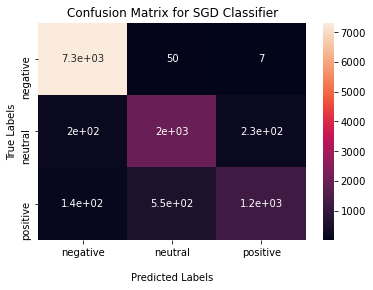

In [836]:
plot_confusion_matrix(test_y, predictions, 'SGD Classifier')

In [837]:
from sklearn.svm import LinearSVC

model = LinearSVC(random_state = 1, dual = False, max_iter = 10000).fit(train_X, train_y)
predictions = model.predict(test_X)
predictions

array([-1,  0, -1, ..., -1, -1, -1], dtype=int64)

In [838]:
print('Mean Absolute Error: {}'.format(mean_absolute_error(test_y, predictions)))
print('-' * 76)
print('Classification Report:', classification_report(test_y, predictions))

Mean Absolute Error: 0.11501024590163934
----------------------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

          -1       0.95      0.99      0.97      7374
           0       0.77      0.83      0.80      2423
           1       0.86      0.62      0.72      1915

    accuracy                           0.90     11712
   macro avg       0.86      0.81      0.83     11712
weighted avg       0.90      0.90      0.89     11712



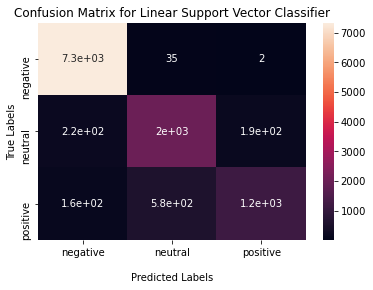

In [839]:
plot_confusion_matrix(test_y, predictions, 'Linear Support Vector Classifier')

# Conclusion

From the results of the aforementoned models, predictions can be made with an accuracy of over 90%, with the Linear Support Vector Classifier being most effective.

The model can be futher optimized for accuracy by a more detailed process of cleaning and grouping of subsets to prevent mislabelling, and better fitting of data in models by specifying and monitoring parametres.


### Footnote
The xgboost library could not be used as it is still incomaptible the lastest version of Python(3.8) as of 09/08/2020.

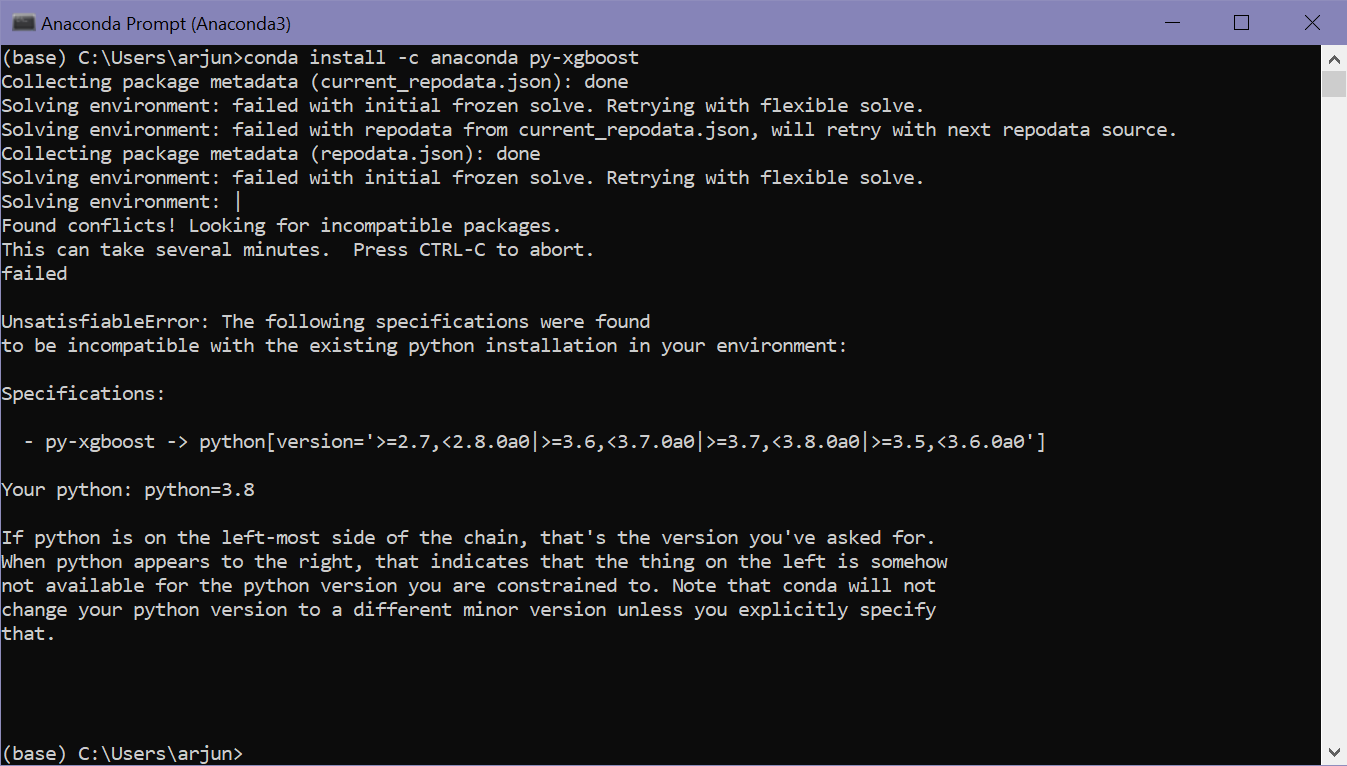
